In [33]:
from keras.layers import Input, merge
from keras.models import Model,Sequential
from layers import VGGNormalize,ReflectionPadding2D,Denormalize,conv_bn_relu,res_conv,dconv_bn_nolinear
from loss import dummy_loss,StyleReconstructionRegularizer,FeatureReconstructionRegularizer,TVRegularizer

import nets

%matplotlib inline

%reload_ext autoreload

%autoreload 2


* Input 3 × 256 × 256
* Reflection Padding (40 × 40) 3 × 336 × 336
* 32 × 9 × 9 conv, stride 1 32 × 336 × 336
* 64 × 3 × 3 conv, stride 2 64 × 168 × 168
* 128 × 3 × 3 conv, stride 2 128 × 84 × 84
* Residual block, 128 filters 128 × 80 × 80
* Residual block, 128 filters 128 × 76 × 76
* Residual block, 128 filters 128 × 72 × 72
* Residual block, 128 filters 128 × 68 × 68
* Residual block, 128 filters 128 × 64 × 64
* 64 × 3 × 3 conv, stride 1/2 64 × 128 × 128
* 32 × 3 × 3 conv, stride 1/2 32 × 256 × 256
* 3 × 9 × 9 conv, stride 1 3 × 256 × 256

In [42]:



model = nets.image_transform_net()
# print model.summary() 

#if tranning

#model = nets.loss_net(net.output,net.input)

print model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
reflectionpadding2d_6 (Reflectio (None, 336, 336, 3)   0           input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 336, 336, 32)  7808        reflectionpadding2d_6[0][0]      
____________________________________________________________________________________________________
batchnormalization_81 (BatchNorm (None, 336, 336, 32)  128         convolution2d_66[0][0]           
___________________________________________________________________________________________

In [35]:
from img_util import deprocess_image
from scipy.misc import imsave
from IPython.core.display import Image, display 

def display_val_img(i,x):
    # save current generated image
    img = x #deprocess_image(x)
    fname = 'output_%d.png' % i
    imsave(fname, img)
    print('Image saved as', fname)
   

    display(Image(fname)) 
    

Found 3 images belonging to 1 classes.
('epoc: ', 0)
(13103.789, 17.192872047424316)
('Image saved as', 'output_0.png')


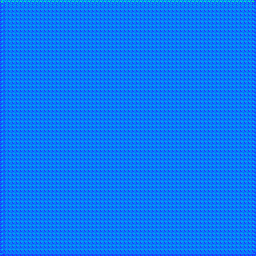

('epoc: ', 1)
(7902.9272, 4.515774965286255)
('epoc: ', 2)
(14103.31, 3.830796003341675)
('epoc: ', 3)
(12679.299, 3.90851092338562)
('epoc: ', 4)
(7848.4487, 3.7666900157928467)
('epoc: ', 5)
(13516.566, 3.858510971069336)
('epoc: ', 6)
(12570.973, 3.8704159259796143)
('epoc: ', 7)
(7860.9072, 3.768789052963257)
('epoc: ', 8)
(13460.293, 3.901503086090088)
('epoc: ', 9)
(12520.434, 3.7749099731445312)
('epoc: ', 10)
(7751.4575, 3.8054821491241455)
('epoc: ', 11)
(13462.957, 3.722337007522583)
('epoc: ', 12)
(12478.788, 3.7441301345825195)
('epoc: ', 13)
(7664.2441, 3.7424349784851074)
('epoc: ', 14)
(13469.057, 3.7335548400878906)
('epoc: ', 15)
(12448.471, 3.825695037841797)
('epoc: ', 16)
(7612.9395, 3.8212971687316895)
('epoc: ', 17)
(13450.602, 3.984447956085205)
('epoc: ', 18)
(12414.422, 4.191371202468872)
('epoc: ', 19)
(7580.6904, 3.8939449787139893)
('epoc: ', 20)
(13406.42, 3.6180078983306885)
('epoc: ', 21)
(12374.436, 3.5920448303222656)
('epoc: ', 22)
(7558.998, 3.6167860

KeyboardInterrupt: 

In [43]:
from keras.optimizers import Adam, SGD,Nadam,Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import time
import numpy as np

from keras.callbacks import TensorBoard

img_width = 256
img_height = 256
nb_epoch = 12*100
train_batchsize = 1 #4
train_image_path = "images/train/"

learning_rate = 1e-3 #1e-3
optimizer = Adam(lr=learning_rate,beta_1=0.99)

model.compile(optimizer,  loss='mean_squared_error')  # Dummy loss since we are learning from regularizes

datagen = ImageDataGenerator()#rescale=1. / 255)

dummy_y = np.zeros((train_batchsize, img_height, img_width, 3)) # Dummy output, not used since we use regularizers to train

tbCallBack = TensorBoard(log_dir='/Graph', histogram_freq=0, write_graph=True, write_images=True)


i=0
for x in datagen.flow_from_directory(train_image_path, class_mode=None, batch_size=train_batchsize,
    target_size=(img_width, img_height), shuffle=False):    
    if i > nb_epoch:
        break
    print("epoc: ", i)
    t1 = time.time()
    hist = model.train_on_batch(x, x.copy())

    print(hist,(time.time() -t1))
    
    if i % 50 == 0:
        val_x = model.predict(x)
        display_val_img(i, val_x[0])
        
    i+=1
    
    